# **Disaster on social media**

In [ ]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

## Cleaning



In [ ]:
# 정확히 모르지만 인코딩 때문에 바로 pd.read_csv가 되지 않음
# 그래서 원본 파일을 sanitizing한 파일을 불러와서 사용

input_file = codecs.open('/content/socialmedia_relevant_cols.csv', 'r',
                         encoding='utf-8', errors='replace')
output_file = open('/content/socialmedia_relevant_cols_clean.csv', 'w')

def sanitize_characters(raw, clean):
    for line in input_file:
        out = line
        output_file.write(line)

sanitize_characters(input_file, output_file)

In [ ]:
questions = pd.read_csv('/content/socialmedia_relevant_cols_clean.csv')
questions.columns = ['text', 'choose_one', 'class_label']
questions.head()

text choose_one  class_label
0                 Just happened a terrible car crash   Relevant            1
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1
2  Heard about #earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             Forest fire near La Ronge Sask. Canada   Relevant            1

In [ ]:
questions.tail()

text  ... class_label
10871  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...  ...           1
10872  Police investigating after an e-bike collided ...  ...           1
10873  The Latest: More Homes Razed by Northern Calif...  ...           1
10874  MEG issues Hazardous Weather Outlook (HWO) htt...  ...           1
10875  #CityofCalgary has activated its Municipal Eme...  ...           1

[5 rows x 3 columns]

In [ ]:
questions.describe()

class_label
count  10876.000000
mean       0.432604
std        0.498420
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000

In [ ]:
# 정규표현식을 사용한 텍스트 전처리

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "") # \S => non space를 표현하며 공백 문자가 아닌 것, +=>one or more
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^a-zA-Z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

text choose_one  class_label
0                 just happened a terrible car crash   Relevant            1
1  our deeds are the reason of this  earthquake m...   Relevant            1
2  heard about  earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             forest fire near la ronge sask  canada   Relevant            1

In [ ]:
clean_questions = pd.read_csv("clean_data.csv", index_col=0)
clean_questions.tail()

text  ... class_label
10854  1 3  earthquake in 9km ssw of anza california ...  ...           1
10855   evacuation order lifted for town of roosevelt     ...           1
10856  see the 16yr old pkk suicide bomber who detona...  ...           1
10857  to conference attendees! the blue line from th...  ...           1
10858  the death toll in a  is suicide car bombing on...  ...           1

[5 rows x 3 columns]

In [ ]:
clean_questions.groupby("class_label").count()

text  choose_one
class_label                  
0            6186        6186
1            4657        4657
2              16          16

In [ ]:
# Tokenization

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

text  ...                                             tokens
0                 just happened a terrible car crash  ...          [just, happened, a, terrible, car, crash]
1  our deeds are the reason of this  earthquake m...  ...  [our, deeds, are, the, reason, of, this, earth...
2  heard about  earthquake is different cities, s...  ...  [heard, about, earthquake, is, different, citi...
3  there is a forest fire at spot pond, geese are...  ...  [there, is, a, forest, fire, at, spot, pond, g...
4             forest fire near la ronge sask  canada  ...      [forest, fire, near, la, ronge, sask, canada]

[5 rows x 4 columns]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
vocab = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

154484 words total, with a vocabulary size of 18095
Max sentence length is 34


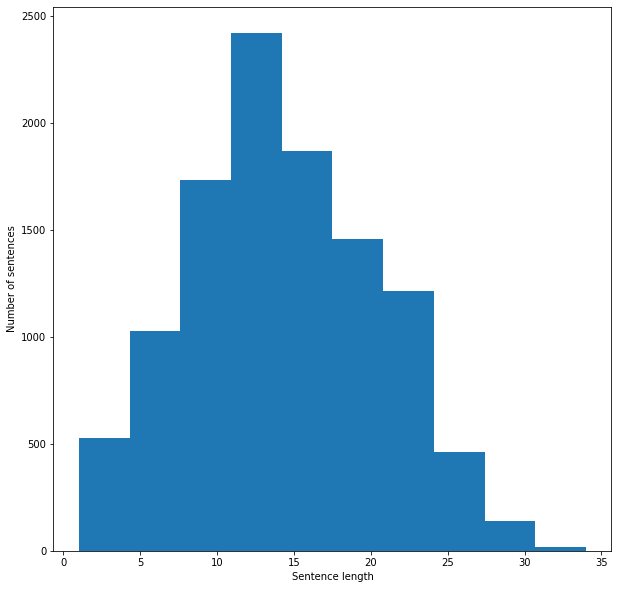

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show();

## Embeddings

### Bag of Words Counts

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

count_vectorizer, X_train_counts, X_test_counts

(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, vocabulary=None),
 <8687x15928 sparse matrix of type '<class 'numpy.int64'>'
 	with 109257 stored elements in Compressed Sparse Row format>,
 <2172x15928 sparse matrix of type '<class 'numpy.int64'>'
 	with 24896 stored elements in Compressed Sparse Row format>)

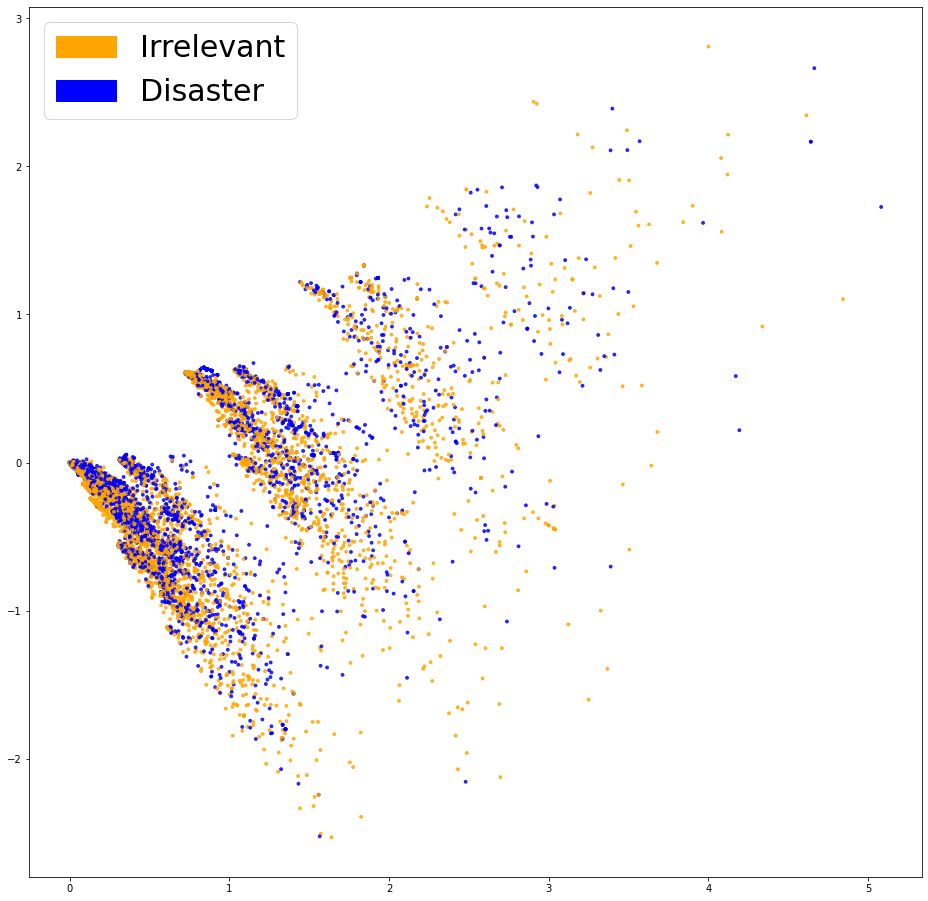

In [ ]:
### Visualizing

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    colors = ['orange', 'blue', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], 
                    s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        green_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size':30})


fig = plt.figure(figsize=(16,16))
plot_LSA(X_train_counts, y_train)
plt.show();

In [ ]:
### Fitting Classfier
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
### Evaluation

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_pred):
    # TP / (TP+FP)
    precision = precision_score(y_test, y_pred, pos_label=None, average='weighted')

    # TP / (TP+FN)
    recall = recall_score(y_test, y_pred, pos_label=None, average='weighted')

    # harmonic mean of precision & recall
    f1 = f1_score(y_test, y_pred, pos_label=None, average='weighted')

    # (TP+TN) / Total
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall= %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.758, recall= 0.761, f1 = 0.759


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                color="white" if cm[i, j] < thresh else "black", fontsize=40)
        
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
        
    return plt

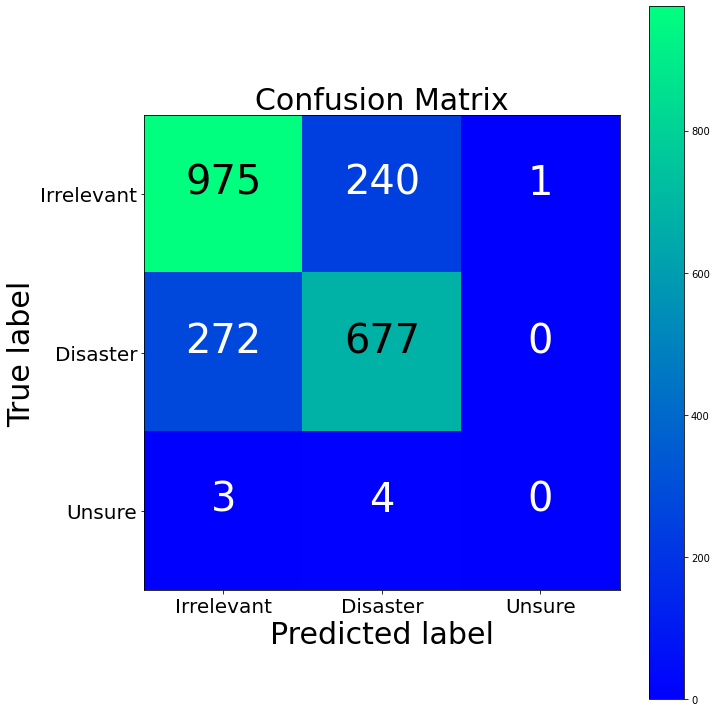

[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion Matrix')
plt.show();
print(cm)

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    #loop for each classes
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)

        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    
    y_pos = np.arange(len(top_words))
    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align='center', alpha=.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Keywords', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos, top_scores, align='center', alpha=.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=.8)
    plt.show();

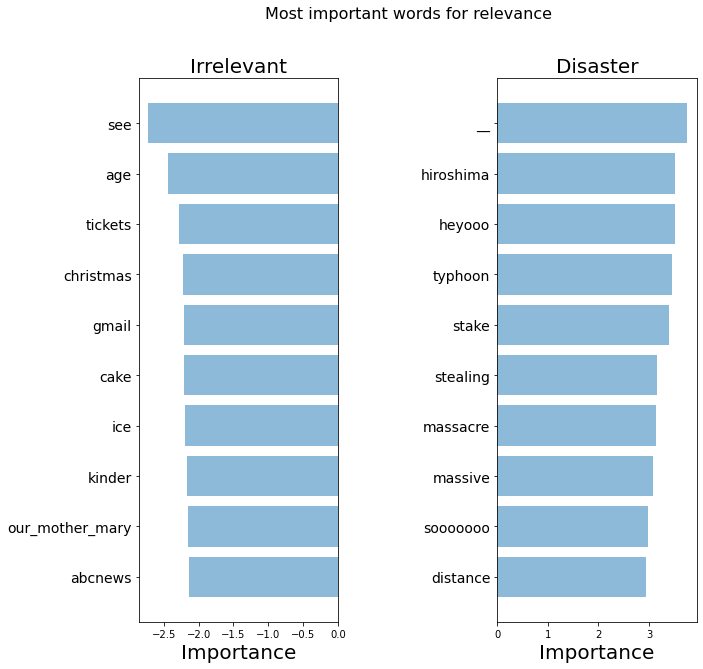

In [ ]:
top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### TFIDF Bag of Words

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf, X_test_tfidf, tfidf_vectorizer

(<8687x15928 sparse matrix of type '<class 'numpy.float64'>'
 	with 109257 stored elements in Compressed Sparse Row format>,
 <2172x15928 sparse matrix of type '<class 'numpy.float64'>'
 	with 24896 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

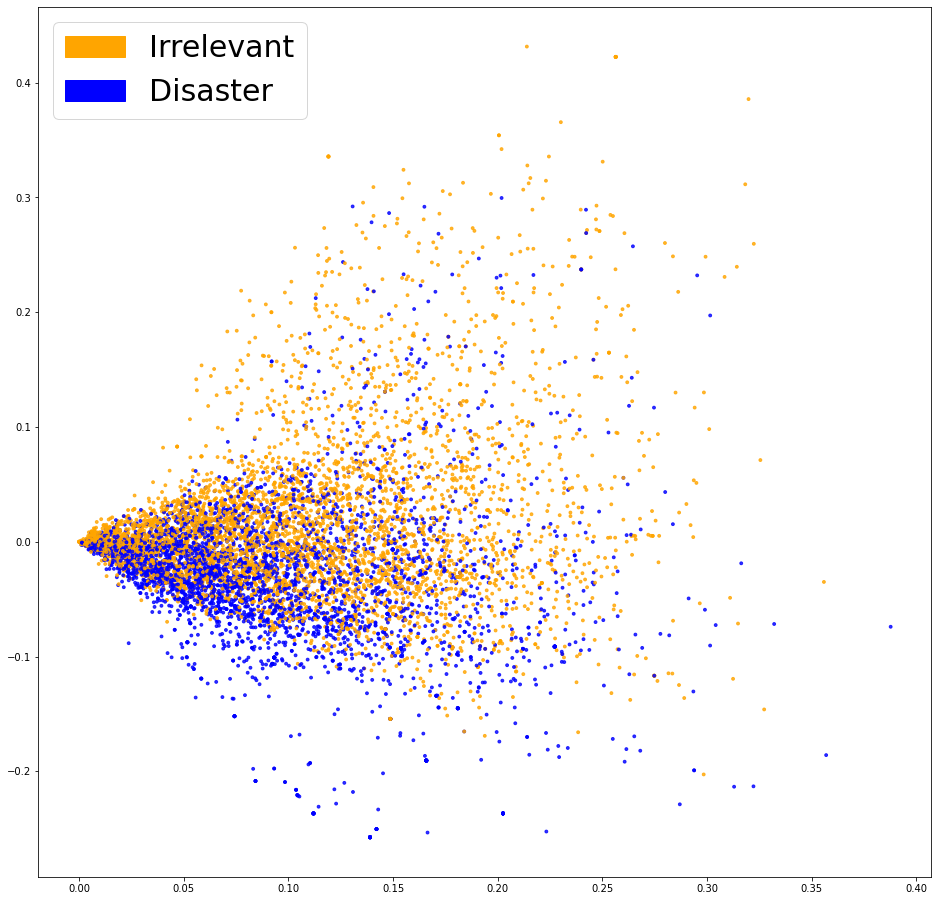

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plot.show();

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, 
                               class_weight='balanced', 
                               solver='newton-cg', 
                               multi_class='multinomial',
                               n_jobs=-1,
                               random_state=40)

clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)

print('accuracy = %.3f, precision = %.3f, recall = %.3f, fl = %.3f' 
      % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.760, precision = 0.757, recall = 0.760, fl = 0.758


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


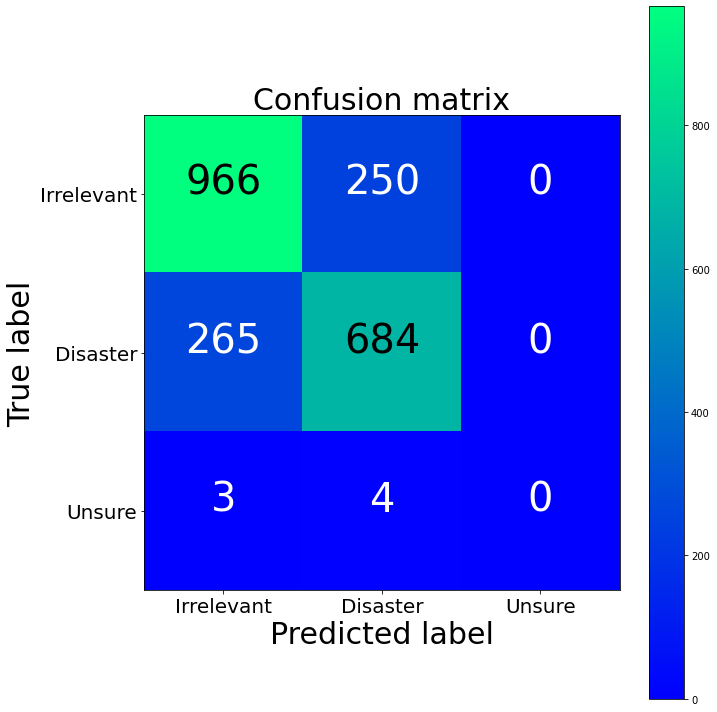

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
Count confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)

fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion matrix')
plt.show();

print("TFIDF confusion matrix")
print(cm2)
print("Count confusion matrix")
print(cm)

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

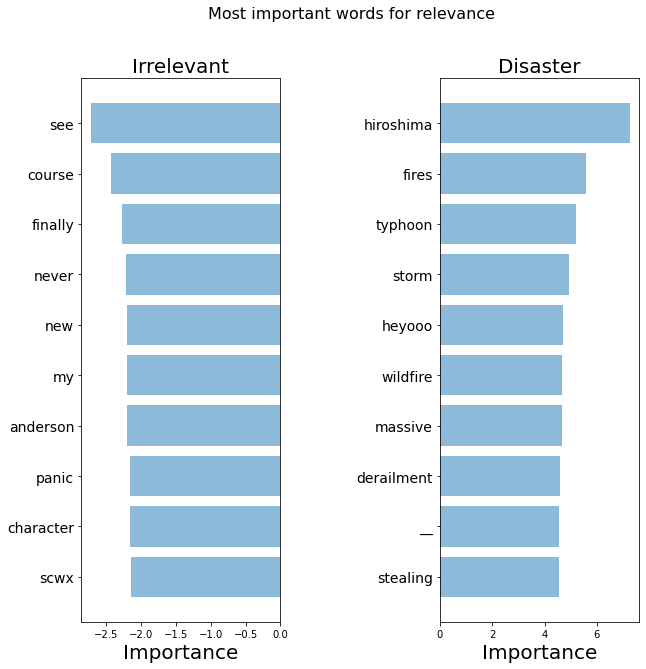

In [ ]:
top_scores =[a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]

bottom_socres = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words,
                     "Most important words for relevance")

### Word2Vec (using gensim google-news-300 pretrained model)

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [ ]:
!python -m gensim.downloader --download word2vec-google-news-300

2021-04-18 08:18:26,394 : gensim.api : INFO : Creating /root/gensim-data
[========================--------------------------] 48.9% 813.3/1662.8MB downloaded

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.6% 1224.0/1662.8MB downloaded

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded
2021-04-18 08:18:54,516 : gensim.api : INFO : word2vec-google-news-300 downloaded
2021-04-18 08:18:54,517 : gensim.api : INFO : Data has been installed and data path is /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
import gensim

# Google's pre-trained Word2Vec model
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    
    if len(tokens_list) < 1:
        return np.zeros(k)

    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)

    return averaged


def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, 
                                                                                vectors, 
                                                                                generate_missing=generate_missing))
    
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                       test_size=.2,
                                                                                       random_state=40)

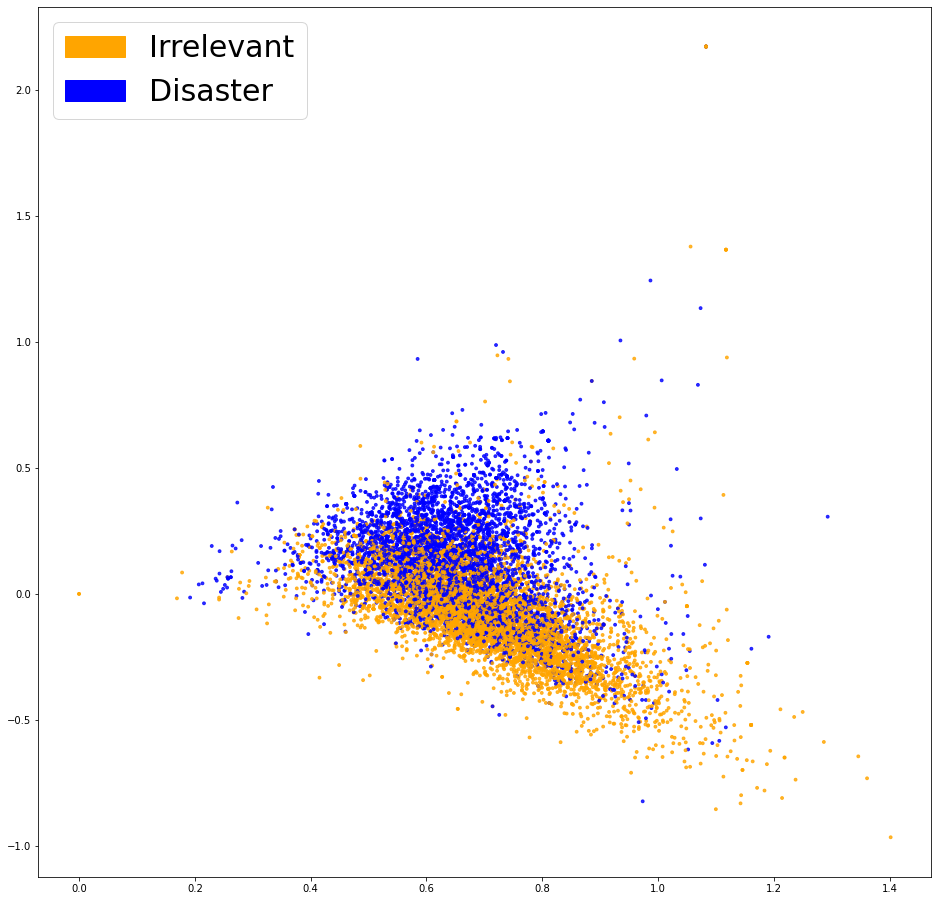

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show();

In [ ]:
clf_w2v = LogisticRegression(C=30.0, 
                             class_weight='balanced', 
                             solver='newton-cg',
                             multi_class='multinomial',
                             random_state=40)

clf_w2v.fit(X_train_word2vec, y_train_word2vec)

y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.772, precision = 0.772, recall = 0.772, f1 = 0.772


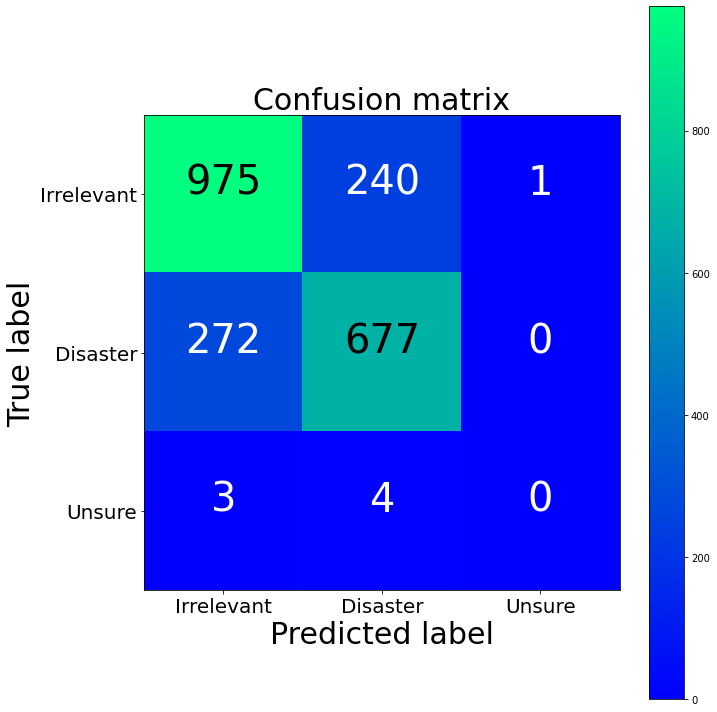

Word2Vec confusion matrix
[[982 229   5]
 [250 694   5]
 [  2   5   0]]
TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
Count confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)

fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant', 'Disaster', 'Unsure'], normalize=False, title='Confusion matrix')
plt.show();

print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("Count confusion matrix")
print(cm)

### LIME (black box explainer)

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 6.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=672ff05c6aa2e54c32b68861e22d88eb6c134789a6ddc9ad068b253849679683
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=.2, random_state=40)
vector_store = word2vec

def word2vec_pipeline(examples):
    
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [ ]:
def explain_one_instance(instance, class_names):

    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    
    return exp

def visualize_one_exp(features, labels, index, class_names=["irrelevant", "relevant", "unknown"]):
    
    exp = explain_one_instance(features[index], class_names=class_names)

    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])

    exp.show_in_notebook(text=True)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: relevant


In [ ]:
visualize_one_exp(X_test_data, y_test_data, 60)

Index: 60
True class: relevant


In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):

    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # Find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word, contributing_weight in listed_explanation:

            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # Average each word's contribution to a class, and sort by impact
    average_contributions = {}
    sorted_contributions = {}
    
    for label, lexica in contributors.items():
    
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())

        for word, scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores)) / sample_size
        
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
                                                        'detractors':detractors,
                                                        'supporters':supporters
        }

    return sorted_contributions


label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'            
}

sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


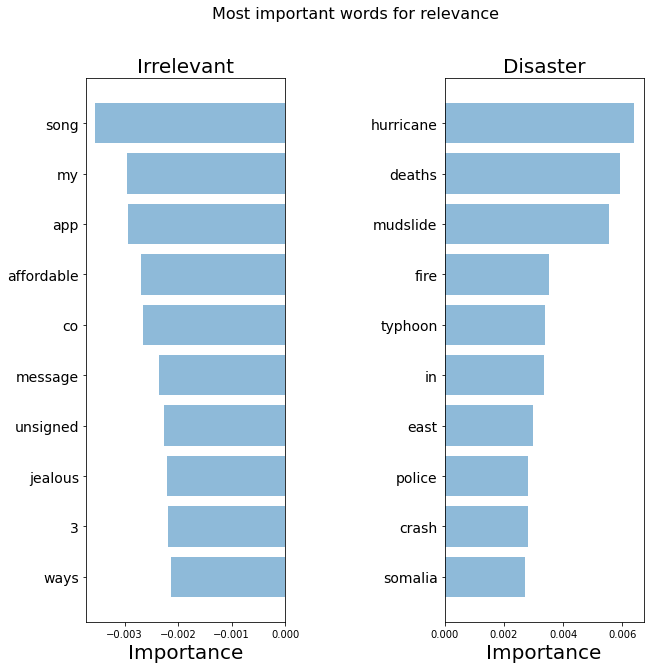

In [ ]:
# first index : Disaster
# second index : 0 for detractors, 1 for supporters
# third index : how many words sampled

top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()

bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words,
                     "Most important words for relevance")

## CNN for text classification

### Embedding text

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocab)

VALIDATION_SPLIT=.2

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions['text'].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions['text'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions['class_label']))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, index in word_index.items():
    embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(embedding_weights.shape)          

Found 19091 unique tokens.
(19092, 300)


### CNN model define

In [ ]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim,
            labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=trainable)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3, 4, 5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)
    
    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, insted of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv == True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    return model

In [ ]:
X_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions['class_label'].unique())), False)

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=5, 
          batch_size=128,
          verbose=1)

Epoch 1/5
68/68 [==============================] - 1s 11ms/step - loss: 0.7515 - acc: 0.5919 - val_loss: 0.5136 - val_acc: 0.7715
Epoch 2/5
68/68 [==============================] - 1s 8ms/step - loss: 0.4884 - acc: 0.7824 - val_loss: 0.4688 - val_acc: 0.7909
Epoch 3/5
68/68 [==============================] - 1s 9ms/step - loss: 0.4428 - acc: 0.8074 - val_loss: 0.4413 - val_acc: 0.8079
Epoch 4/5
68/68 [==============================] - 1s 9ms/step - loss: 0.3959 - acc: 0.8331 - val_loss: 0.4307 - val_acc: 0.8121
Epoch 5/5
68/68 [==============================] - 1s 8ms/step - loss: 0.3662 - acc: 0.8478 - val_loss: 0.4407 - val_acc: 0.8075
